In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
import seaborn as sns
import json
from pprint import pprint
from datetime import timedelta
import os

# Intro

We have attached our Jupyter server to three different repositories in our Pachyderm pipline DAG:

- **trips** - This repo is populated with a daily file that records the number of bicycle trips recorded by NYC's citibike bike sharing company on that particular day (data from [here](https://www.citibikenyc.com/system-data)).
- **sales** - This repo includes a single CSV file called `sales.csv`.  `sales.csv` is updated daily by a pipeline that processes each file in `trips` to calculate sales for the day.  Note, here we are using a fictional multiplier, $5/trip, to calculate daily "sales" (i.e., these are not actually the sales figures for citibike).
- **weather** - This repo is populated daily with a JSON file representing the weather forecast for that day from [forecast.io](https://darksky.net/forecast/40.7127,-74.0059/us12/en).

We attached to the `trips` and `weather` repos at commit number 30, which corresponds to the data versioned on 7/31/2016.  We did this, because on 7/30/2016 and 7/31/2016 we saw a sharp drop in our sales, and we want to try and understand, interactively, why we might have seen this drop in sales.  

By attaching to these separate points in our DAG (`trips`, `weather`, and `sales`) we can bring our data together at a particular commit (i.e., a particular point in history), without explicitly planning a pipeline stage that takes these repos as input.

# Import sales data from the `sales` repo

Let's first grab our sales data from the `sales` repo:

In [2]:
salesDF = pd.read_csv('/pfs/sales/sales.csv', names=['Date', 'Sales'])
salesDF['Date'] = pd.to_datetime(salesDF['Date'])
salesDF.set_index('Date', inplace=True)

In [3]:
salesDF.head()

,Sales
Date,
2016-07-01,198325
2016-07-02,179175
2016-07-03,176735
2016-07-04,174295
2016-07-05,218680


# Import trip data from the `trips` repo, join with the sales data

We can then grab the trip count data from the `trips` repo, put that into a separate dataframe, and merge the two data frames.  This way we can join our data from multiple repos interactively to try and draw some conclusions.

In [4]:
trip_data = []

for fn in os.listdir('/pfs/trips/'):
    
    if os.path.isfile('/pfs/trips/' + fn): 
                     
        data = pd.read_csv('/pfs/trips/' + fn)

        trips = data.ix[0]['Trips over the past 24-hours (midnight to 11:59pm)']
        trip_data.append([data.ix[0]['Date'], trips])

tripsDF = pd.DataFrame(trip_data, columns=['Date','Trips'])
tripsDF['Date'] = pd.to_datetime(tripsDF['Date'])
tripsDF.set_index('Date', inplace=True)

In [5]:
tripsDF.head()

,Trips
Date,
2016-07-01,39665
2016-07-02,35835
2016-07-03,35347
2016-07-04,34859
2016-07-05,43736


In [6]:
dataDF = salesDF.join(tripsDF)

In [7]:
dataDF.head()

,Sales,Trips
Date,,
2016-07-01,198325,39665
2016-07-02,179175,35835
2016-07-03,176735,35347
2016-07-04,174295,34859
2016-07-05,218680,43736


# Import supplemental JSON weather data from the `weather` repo, and join with our other data

Finally, we will pull in the JSON weather data from the `weather` repo and again merge that with the sales and trip data.  We suspect that the weather likely had something to do with the poor sales on the 30th and 31st of July.  In particular we expect that precipitation might have led to the poor sales, so we will extract the daily precipitation probabilities and join that with our previously created dataframe.

In [8]:
precip_data = []

for fn in os.listdir('/pfs/weather/'):
    
    if os.path.isfile('/pfs/weather/' + fn):

        with open('/pfs/weather/' + fn) as data_file:    
            data = json.load(data_file)

        precip = data['daily']['data'][0]['precipProbability']
        precip_data.append([fn, precip])

In [9]:
precipDF = pd.DataFrame(precip_data, columns=['Date', 'Precipitation Probability'])
precipDF['Date'] = pd.to_datetime(precipDF['Date'])
precipDF.set_index('Date', inplace=True)

In [10]:
precipDF.head()

,Precipitation Intensity
Date,
2016-07-01,0.83
2016-07-02,0.00
2016-07-03,0.00
2016-07-04,0.59
2016-07-05,0.89


In [11]:
dataDF = dataDF.join(precipDF)

In [12]:
dataDF.head()

,Sales,Trips,Precipitation Intensity
Date,,,
2016-07-01,198325,39665,0.83
2016-07-02,179175,35835,0.00
2016-07-03,176735,35347,0.00
2016-07-04,174295,34859,0.59
2016-07-05,218680,43736,0.89


# Visualize the sales in the context of weather

Finally, we confirm our suspicions by visualizing the precipitation probabilities with the sales data:

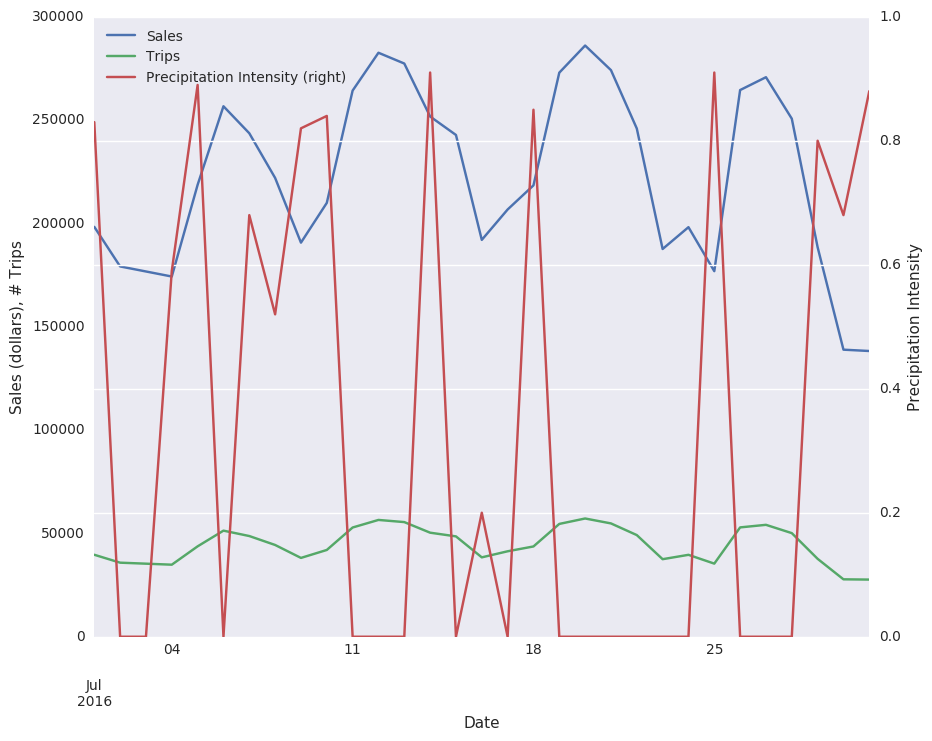

In [13]:
ax = dataDF.plot(secondary_y=['Precipitation Probability'], figsize=(10, 8))
ax.set_ylabel('Sales (dollars), # Trips')
ax.right_ax.set_ylabel('Precipitation probability')

We can see that their was a probability of precipitation in NYC above 70% both of the days in question.  This is likely to be the explanation for the poor sales.  Of course, we can attach our Jupyter notebook to any Pachyderm repos at at commit to explore other unexpected behavior, develop further analyses, etc.